<a href="https://colab.research.google.com/github/AnumahAdeizaStephen/ResNet-Tutorial-/blob/main/AI_GRID_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network Pipeline for Particle Interaction Event Anaysis**
## **Objective**


```
Replace the existing signal processing pipeline with neural networks for:
1.  Main event detection and localization.
2.  Amplitude prediction & Pulse time estimation.
```
## **Existing Approach:**

Input:.bin, Output: Event visualization plots


```
1.  Uses an 11X11 grid to model events, and each has multiple waveforms from different pixels.
2.  Sets channel flags: 1 (8 anode: neighbouring events), 2 (cathode), 3 (anode: main event), with each waveform having 160 time samples.
3.  Amplitude estimation (low - high)
4.  Pulse time (curve) fitting (using the stepish_func error function to find pulse timing).
5.  Single-pixel event filtering: Looks for events with exactly 1 (neighbouring events), 2 (cathode), 3 (anode)
6.  Calibration: per-pixel gain calibration using Gaussian fits.
7.  Energy calculation: converts amplitude to keV, using hard-coded algorithms.
```
## **Insights**


```
- 11x11 grid: detector pixel array.
- All pixels triggared in each event.
- A, t: Amplitude and pulse time (in samples: 0-158 range).
```
## **Method**



```
(Load .bin file using the existing 'Ideas' class.)
1.  Extract waveforms and group by timestamp (events).
2.  Create 11x11 x 160 data cubes (pixels x time samples).
3.  Train a convolutional Neural Network to:
    - Detect main event location (classification)
    - Predict amplitude (regresssion)
    - Predict pulse time (regression)
4.  Use existing calculated ampliutdes/tines as ground truth.
```



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as  nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from pathlib import Path
import os
import yaml
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.special import erf

from google.colab import drive
drive.mount('/content/drive')

#Set random seeds for reporoducibility
torch.manual_seed(42)
np.random.seed(42)

#Path to binary data and config file
BINARY_DATA = "/content/scan_x0.13_y0.12_2025-10-23__12_33_43.bin"
CONFIG = '/content/config.yaml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Path to config file
CONFIG = '/content/config.yaml'

DATA_PATH = 'drive/MyDrive/ColabNotebooks/ScatterAnalysis/data/'

## BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.08_2025-10-23__11_48_39.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.10_2025-10-23__12_10_59.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.13_y0.12_2025-10-23__12_33_43.bin'
# BINARY_DATA = f'{DATA_PATH}/scan_x0.15_y0.0_2025-09-09__15_46_28.bin'
BINARY_DATA = '/content/scan_x0.13_y0.12_2025-10-23__12_33_43.bin'

In [16]:
!ls

config.yaml  scan_x0.13_y0.12_2025-10-23__12_33_43.bin
drive	     scan_x0.13_y0.12_2025-10-23__12_33_43.npy
sample_data


Define the calculate_pulse_time_simple function (to speedily calculate the pulse time using threshold crossing), fit_waveform(function to fit a single waveform - modified for ProcessPoolExecutor), and the Ideas class (to load the data).

**Calculate ground truth - calculate_ground_truth_parallel():**

For each event (grouped by timestamp):

1.Loops through every pixel (channel) involved in that event.

2.Finds the pulse amplitude by subtracting the mean of a “low” window from a “high” window in the waveform. (This measures how strong the pulse is.)

3.Finds the pulse time → by using calculate_pulse_time_simple(w, 0.3), which finds when the waveform crosses 30% of its peak height. (This approximates the signal arrival time.)

4.Labels the pixel as main anode, secondary anode, or cathode, via pixel_type.

5.Stores all this in a new DataFrame (self.ground_truth_df).

In [24]:
import concurrent.futures

def calculate_pulse_time_simple(w, threshold_ratio=0.3):
    """Faster pulse time detection using threshold crossing"""
    baseline = np.mean(w[:10])  # First 10 samples as baseline
    peak = np.max(w)
    threshold = baseline + threshold_ratio * (peak - baseline)

    # Find where waveform crosses threshold
    above_threshold = w > threshold
    if not np.any(above_threshold):
        return np.nan

    # Find first crossing
    cross_idx = np.argmax(above_threshold)

    # Linear interpolation for sub-sample accuracy
    if cross_idx > 0:
        t0 = cross_idx - 1
        t1 = cross_idx
        y0 = w[t0] - threshold
        y1 = w[t1] - threshold
        if y0 != y1:
            fractional = -y0 / (y1 - y0)
            return t0 + fractional
    return cross_idx


class Ideas:
    """Wrapper around the existing Ideas class to load and preprocess data"""

    def __init__(self, bin_file_path, config_path=CONFIG):
        self.bin_file_path = bin_file_path
        self.config = yaml.safe_load(open(config_path))

        # Load data using the existing pattern
        self.load_binary_data()
        self.preprocess_events()

    def load_binary_data(self):
        """Load binary data using the existing data structure"""
        filename = self.bin_file_path
        outfilename = Path(filename).stem + ".npy"

        if os.path.exists(outfilename):
            print(f"Loading cached data from {outfilename}")
            with open(outfilename, "rb") as f:
                file_size = np.load(f)
                record_size = np.load(f)
                num_records = np.load(f)
                waveforms = np.load(f)
                timestamp = np.load(f)
                x = np.load(f)
                y = np.load(f)
                channel_flag = np.load(f)
        else:
            # Create numpy memmap from binary file (same as original code)
            data_type = np.dtype([
                ("length", ">u2"), ("log_type", ">u2"), ("packet_count", ">u2"),
                ("packet_flags", ">u1"), ("system_number", ">u1"), ("timestamp", ">u8"),
                ("source_id", ">u1"), ("trig_type", ">u1"), ("user_status", ">u2"),
                ("event_id", ">u4"), ("pps_timestamp", ">u4"), ("channel_flag", ">u1"),
                ("cell_pointer", ">u1"), ("x_address", ">u1"), ("y_address", ">u1"),
                ("waveforms", (">H", (160,))),
            ])

            file_size = os.path.getsize(filename)
            record_size = 32 + 160 * 2  # 352 bytes per record
            num_records = file_size // record_size
            memmap = np.memmap(filename, dtype=data_type, mode="r", shape=(num_records))

            # Fix timestamp overflow (same as original)
            prev_timestamp = memmap["timestamp"][0]
            overflow_increment = 0
            adjusted_timestamps = np.zeros_like(memmap["timestamp"])
            for i, ts in enumerate(memmap["timestamp"]):
                if ts < prev_timestamp:
                    overflow_increment += prev_timestamp
                adjusted_timestamps[i] = ts + overflow_increment
                prev_timestamp = ts

            waveforms = memmap["waveforms"].byteswap().view(memmap["waveforms"].dtype.newbyteorder())
            timestamp = adjusted_timestamps.byteswap().view(adjusted_timestamps.dtype.newbyteorder())
            x = memmap["x_address"].byteswap().view(memmap["x_address"].dtype.newbyteorder())
            y = memmap["y_address"].byteswap().view(memmap["y_address"].dtype.newbyteorder())
            channel_flag = memmap["channel_flag"].byteswap().view(memmap["channel_flag"].dtype.newbyteorder())

            # Save to cache
            with open(outfilename, "wb") as f:
                np.save(f, file_size)
                np.save(f, record_size)
                np.save(f, num_records)
                np.save(f, waveforms)
                np.save(f, timestamp)
                np.save(f, x)
                np.save(f, y)
                np.save(f, channel_flag)

        self.waveforms = waveforms
        self.timestamps = timestamp
        self.x_coords = x
        self.y_coords = y
        self.channel_flags = channel_flag

        print(f"Loaded {len(self.waveforms)} waveform records")
        print(f"Data shapes - waveforms: {waveforms.shape}, timestamps: {timestamp.shape}")

    def preprocess_events(self):
        """Group data by timestamp to form complete events"""
        # Create DataFrame for easy grouping
        self.df = pd.DataFrame({
            'timestamp': self.timestamps,
            'x': self.x_coords,
            'y': self.y_coords,
            'channel_flag': self.channel_flags
        })

        # Group by timestamp to get complete events
        self.event_groups = self.df.groupby('timestamp')
        print(f"Found {len(self.event_groups)} unique events")


    def calculate_ground_truth_parallel(self):
      print("Calculating ground truth...")
      wcfg = self.config['waveform']

      amplitudes = []
      pulse_times = []
      event_indices = []
      pixel_types = []

      print("Processing events...")
      for timestamp, group_df in tqdm(self.event_groups, total=len(self.event_groups)):
          group_waveforms = self.waveforms[group_df.index]

          for idx, (row_idx, row) in enumerate(group_df.iterrows()):
              w = group_waveforms[idx]

              if row.channel_flag == 1:  # Anode
                  low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                  high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)  # 30% threshold

                  is_main = self.is_main_event(group_df, row.x, row.y)
                  pixel_type = 1 if is_main else 2

              elif row.channel_flag == 0:  # Cathode
                  low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_high_lim"][1]])
                  high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])
                  amplitude = high - low

                  pulse_time = calculate_pulse_time_simple(w, 0.3)
                  pixel_type = 0
              else:
                  continue

              amplitudes.append(amplitude)
              pulse_times.append(pulse_time)
              event_indices.append(row_idx)
              pixel_types.append(pixel_type)

      self.ground_truth_df = pd.DataFrame({
          'original_index': event_indices,
          'amplitude': amplitudes,
          'pulse_time': pulse_times,
          'pixel_type': pixel_types
      })

      print(f"Completed in seconds - {len(self.ground_truth_df)} events")


    def is_main_event(self, event_df, x, y):
        """Determine if this anode is the main event in its timestamp group"""
        anodes = event_df[event_df.channel_flag == 1]
        if len(anodes) == 1:
            return True  # Only one anode = main event

        # For multiple anodes, use amplitude to determine main event
        # This is a heuristic - will be improved with the NN
        amplitudes = []
        for idx, row in anodes.iterrows():
            w = self.waveforms[idx]
            low = np.mean(w[self.config['waveform']["anode_low_lim"][0]:self.config['waveform']["anode_low_lim"][1]])
            high = np.mean(w[self.config['waveform']["anode_high_lim"][0]:self.config['waveform']["anode_high_lim"][1]])
            amplitudes.append(high - low)

        max_amp_idx = np.argmax(amplitudes)
        main_anode = anodes.iloc[max_amp_idx]
        return main_anode.x == x and main_anode.y == y


    def generate_event_plots(self, output_dir="output/events", single_pixel_only=False):
        """Generate event PDF plots - equivalent to 'events' command. Saves them in the events folder"""
        output_folder = Path(output_dir) / Path(self.bin_file_path).stem
        output_folder.mkdir(parents=True, exist_ok=True)

        wcfg = self.config['waveform']

        print(f"Generating event plots in {output_folder}")

        for timestamp, event_df in tqdm(self.event_groups, desc="Generating event plots"):
            output_filename = output_folder / f"event_{timestamp}.pdf"

            if output_filename.exists():
                print(f"Not recreating {output_filename}")
                continue

            # Filter for single-pixel events if requested
            if single_pixel_only:
                n_triggered = len(event_df[event_df.channel_flag == 3])
                if n_triggered != 1:
                    continue

            # Create the 11x12 grid (detector layout)
            fig, axs = plt.subplots(11, 12, figsize=(20, 10), sharex=True, sharey=True)

            # Hide unused subplots
            for row in range(11):
                if row <= 1:  # Adjust based on actual layout
                    continue
                axs[row, 11].set_visible(False)

            fig.suptitle(f"Timestamp {timestamp}")

            amplitude_cathode = None
            t_anode = None
            t_cathode = None

            # Plot each pixel in the event
            for idx, (row_idx, row) in enumerate(event_df.iterrows()):
                w = self.waveforms[row_idx]

                if row.channel_flag == 0:
                  continue

                # Determine subplot position
                if 255 in (row.x, row.y):  # Special pixels
                    ax = axs[0, 11]
                else:
                    ax = axs[11 - int(row.y), int(row.x) - 1]

                # Pixel coordinate label
                ax.text(0.95, 0.05, f"({row.x}, {row.y})", transform=ax.transAxes,
                      fontsize=8, verticalalignment="bottom", horizontalalignment="right")

                # Color coding by channel type
                colors = {0: "tab:red", 1: "tab:blue", 2: "tab:purple", 3: "tab:green"}
                ax.plot(w, colors[row.channel_flag], alpha=0.5)

                # Calculate amplitude and timing
                if row.channel_flag == 1:  # Anode
                    low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                    high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                    amplitude = high - low

                    # Mark amplitude regions
                    ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta")
                    ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta")

                    # Calculate pulse time
                    t_anode = self.calculate_pulse_time_simple(w)
                    ax.text(0.05, 0.95, f"A={amplitude:.2f}\nt={t_anode:.0f}",
                          transform=ax.transAxes, fontsize=8, verticalalignment="top")

                elif row.channel_flag == 0:  # Cathode
                    low = np.mean(w[wcfg["cathode_low_lim"][0]:wcfg["cathode_low_lim"][1]])
                    high = np.mean(w[wcfg["cathode_high_lim"][0]:wcfg["cathode_high_lim"][1]])

                    if amplitude_cathode is not None:
                        print("Multiple cathode events in one timestamp")
                        continue

                    amplitude_cathode = high - low
                    ax.plot([wcfg["cathode_low_lim"][0], wcfg["cathode_low_lim"][1]], [low, low], "magenta")
                    ax.plot([wcfg["cathode_high_lim"][0], wcfg["cathode_high_lim"][1]], [high, high], "magenta")

                    t_cathode = self.calculate_pulse_time_simple(w)
                    ax.text(0.05, 0.95, f"A={amplitude_cathode:.2f}\nt={t_cathode:.0f}",
                          transform=ax.transAxes, fontsize=8, verticalalignment="top")

            # Add event statistics
            if t_cathode is not None and t_anode is not None:
                nums = event_df.groupby("channel_flag").size()
                dt = t_cathode - t_anode

                info = "channel_flag amounts\n" + "\n".join([f"{k}: {v}" for k, v in nums.items()])
                info += f"\ndt = {dt:.0f} ns"

                axs[1, 11].text(0.5, 0.5, info, transform=axs[1, 11].transAxes,
                              fontsize=8, verticalalignment="center", horizontalalignment="center")
                axs[1, 11].axis("off")

            plt.tight_layout()
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(output_filename, bbox_inches="tight")
            plt.close()

        print(f"Event plot generation complete")

In [25]:
# Initialize data loader with .bin file
print("Loading detector data...\n")
data_loader = Ideas(BINARY_DATA)

Loading detector data...

Loading cached data from scan_x0.13_y0.12_2025-10-23__12_33_43.npy
Loaded 954055 waveform records
Data shapes - waveforms: (954055, 160), timestamps: (954055,)
Found 86278 unique events


In [26]:
# Data summary
print("--- DATA SUMMARY ---")
print(f"Total waveforms: {len(data_loader.waveforms)}")
print(f"Unique events: {len(data_loader.event_groups)}")

--- DATA SUMMARY ---
Total waveforms: 954055
Unique events: 86278


In [27]:
# Calculate ground truth using existing pipeline
data_loader.calculate_ground_truth_parallel()

print(f"Ground truth samples: {len(data_loader.ground_truth_df)}")

Calculating ground truth...
Processing events...


100%|██████████| 86278/86278 [14:34<00:00, 98.61it/s] 


Completed in seconds - 758746 events
Ground truth samples: 758746


# **2.  Bin Data Exploration**
i. Overall Data Quality Report

In [28]:
def data_quality_report(data_loader):
    """Comprehensive data quality assessment"""
    print("=== DATA QUALITY REPORT ===")

    # Event statistics
    total_events = len(data_loader.event_groups)
    pixel_counts = [len(group) for _, group in data_loader.event_groups]

    print(f"Total events: {total_events}")
    print(f"Events with 1 pixel: {sum(1 for x in pixel_counts if x == 1)}")
    print(f"Events with 3-9 pixels: {sum(1 for x in pixel_counts if 3 <= x <= 9)}")
    print(f"Events with 10+ pixels: {sum(1 for x in pixel_counts if x >= 10)}")

    # Signal quality
    amplitudes = data_loader.ground_truth_df['amplitude'].dropna()
    print(f"Amplitude range: {amplitudes.min():.1f} - {amplitudes.max():.1f}")
    print(f"Mean amplitude: {amplitudes.mean():.1f} ± {amplitudes.std():.1f}")

    # Coordinate analysis
    valid_coords = data_loader.df[(data_loader.df.x < 11) & (data_loader.df.y < 11)]
    print(f"Valid coordinates: {len(valid_coords)} / {len(data_loader.df)}")

data_quality_report(data_loader)

=== DATA QUALITY REPORT ===
Total events: 86278
Events with 1 pixel: 0
Events with 3-9 pixels: 25201
Events with 10+ pixels: 61077
Amplitude range: -279.6 - 6926.6
Mean amplitude: 5.3 ± 73.0
Valid coordinates: 761793 / 954055


ii. 2D imagae generation from the Bin file

VISUALIZING WITH ALL ANODE TYPES...
Visualizing event with timestamp 2487432375

Total triggered pixels: 10
All anodes (channels 1+3): 9
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 8
  Cathode: 1
  Special Anode: 1

FINAL: 9 anode boxes plotted + 0 cathode boxes


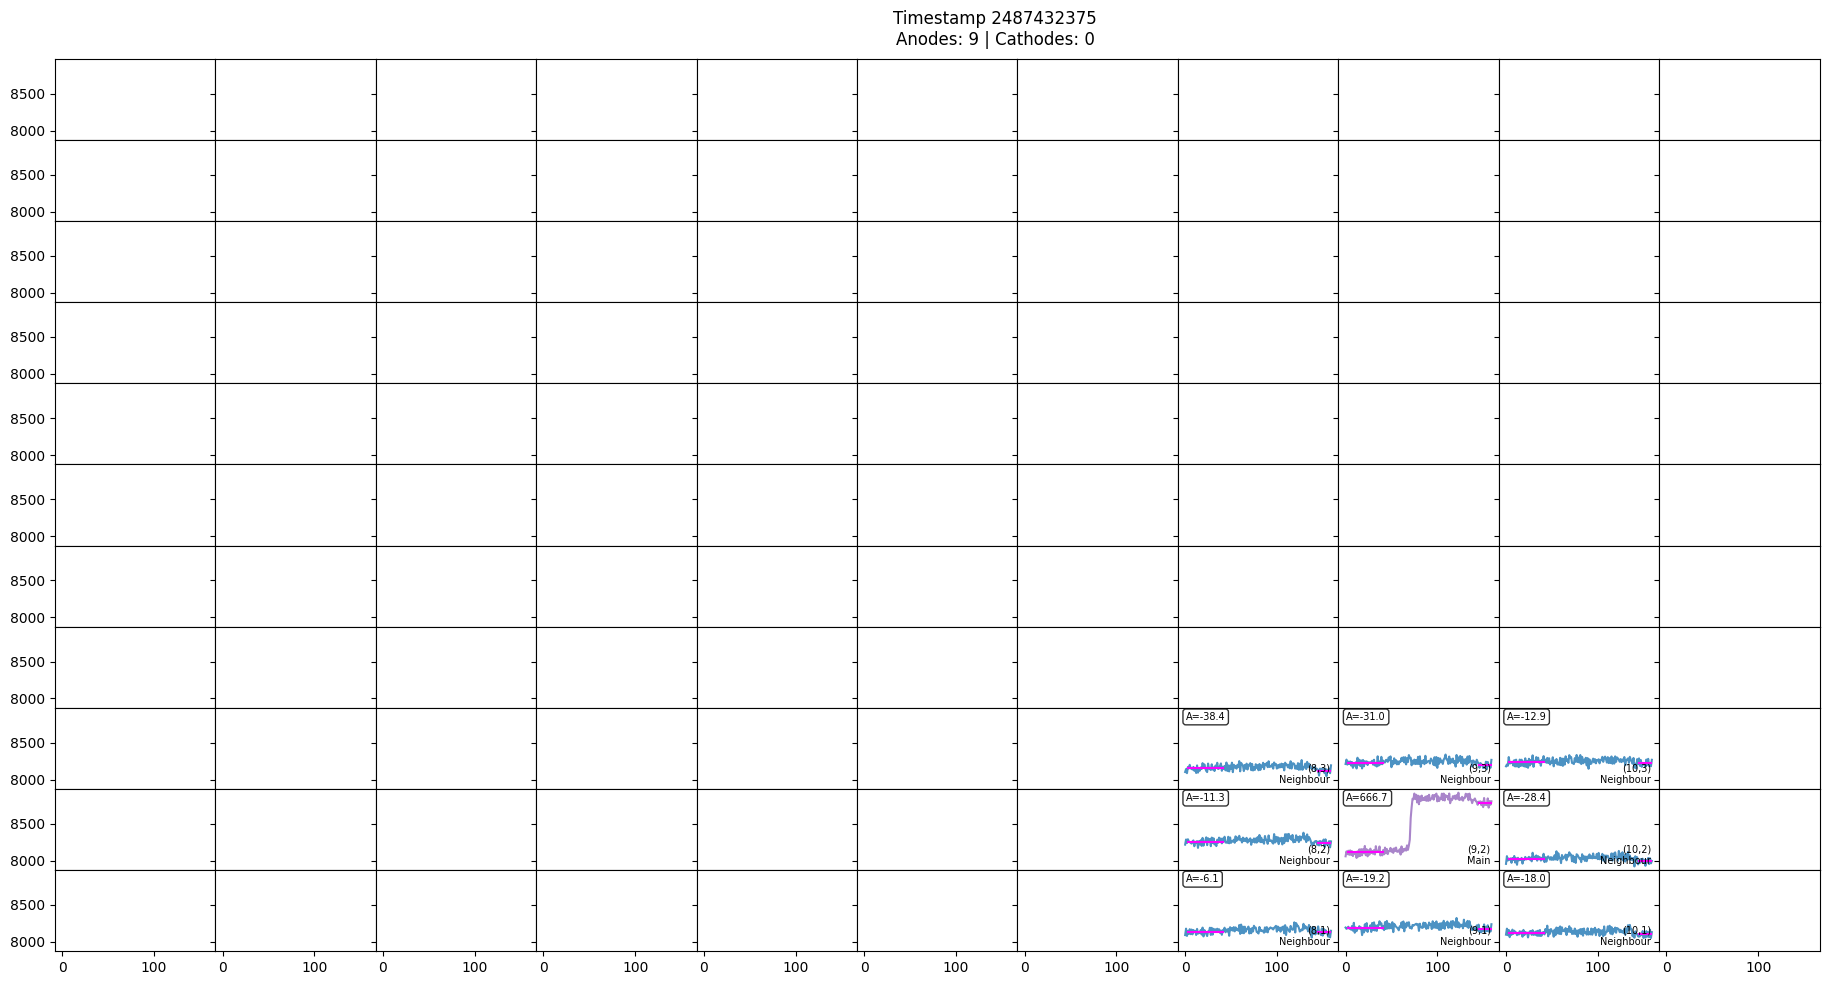

----------------------------------------------------------------------
Visualizing event with timestamp 2487504773

Total triggered pixels: 7
All anodes (channels 1+3): 6
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 5
  Cathode: 1
  Special Anode: 1

FINAL: 6 anode boxes plotted + 0 cathode boxes


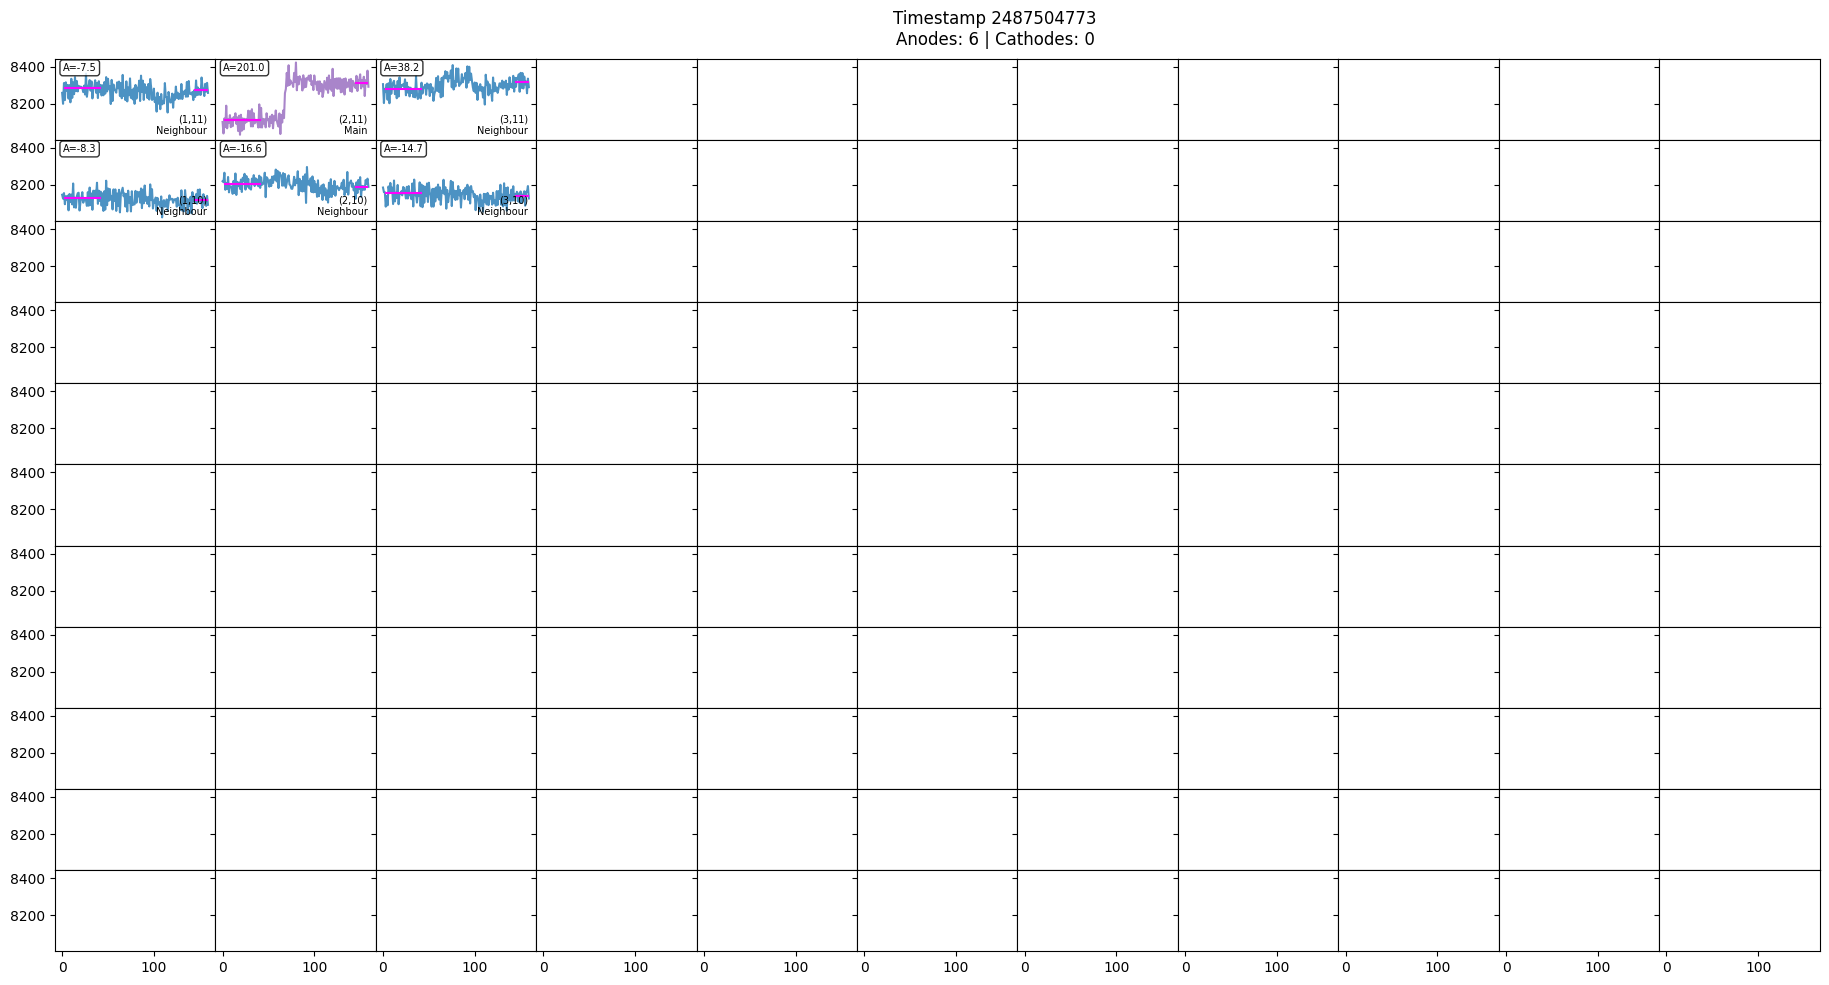

----------------------------------------------------------------------
Visualizing event with timestamp 2488342389

Total triggered pixels: 7
All anodes (channels 1+3): 6
Cathodes (channel 2): 0 

Detailed channel breakdown:
  Main Anode: 5
  Cathode: 1
  Special Anode: 1

FINAL: 6 anode boxes plotted + 0 cathode boxes


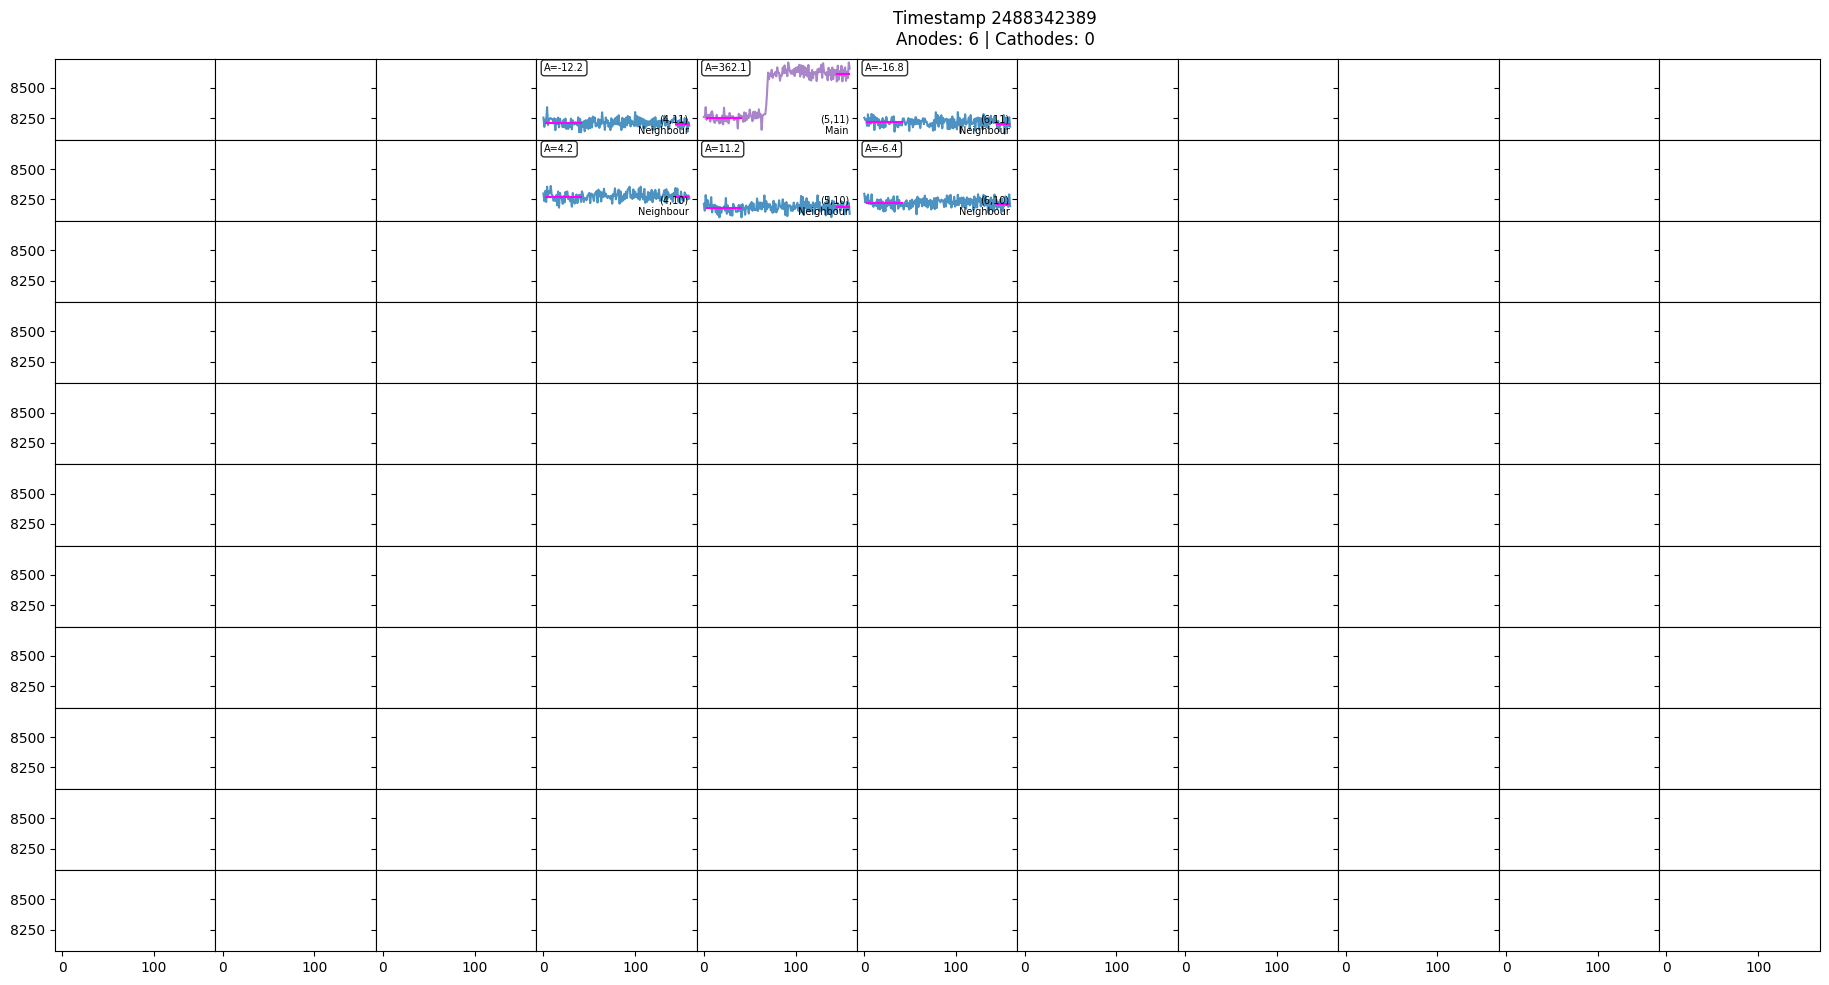

----------------------------------------------------------------------


In [29]:
def visualize_event_all_anodes(data_loader, timestamp_index=0):
    """Visualize event treating ALL anode types (1,2,3) as anodes"""
    timestamps = list(data_loader.event_groups.groups.keys())
    timestamp = timestamps[timestamp_index]
    event_df = data_loader.event_groups.get_group(timestamp)

    print(f"Visualizing event with timestamp {timestamp}\n")

    # GROUP ALL ANODE TYPES TOGETHER
    anode_mask = event_df['channel_flag'].isin([1, 3])  # Channels 1,2,3 are all anodes!
    cathode_mask = event_df['channel_flag'] == 0

    anodes_df = event_df[anode_mask]
    cathodes_df = event_df[cathode_mask]

    print(f"Total triggered pixels: {len(event_df)}")
    print(f"All anodes (channels 1+3): {len(anodes_df)}")
    print(f"Cathodes (channel 2): {len(cathodes_df)} \n")

    # Detailed channel breakdown
    channel_counts = event_df['channel_flag'].value_counts()
    print("Detailed channel breakdown:")
    channel_names = {1: 'Main Anode', 2: 'Cathode', 3: 'Special Anode'}
    for channel, count in channel_counts.items():
        name = channel_names.get(channel, f'Unknown[{channel}]')
        print(f"  {name}: {count}")

    # Create 11x12 grid
    fig, axs = plt.subplots(11, 12, figsize=(20, 10), sharex=True, sharey=True)

    # Hide the cathode (two top-right) boxes explicitly
    axs[0, 11].set_visible(False)
    axs[1, 11].set_visible(False)

    # Hide the extra column subplots
    for row in range(11):
        if row <= 1:
            continue
        axs[row, 11].set_visible(False)

    fig.suptitle(f"Timestamp {timestamp}\nAnodes: {len(anodes_df)} | Cathodes: {len(cathodes_df)}")

    wcfg = data_loader.config['waveform']
    x = np.arange(160)

    # Track plotted positions
    used_positions = set()
    anode_count = 0
    cathode_count = 0

    # PLOT ALL ANODES (Channels 1, 2, 3)
    for j, (idx, row) in enumerate(anodes_df.iterrows()):
        w = data_loader.waveforms[anodes_df.index[j]]

        # Coordinate mapping
        if 255 in (row.x, row.y):
            grid_row, grid_col = 0, 11
            position_key = "special"
        else:
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1
            position_key = f"{grid_row},{grid_col}"

        # Check for duplicates
        if position_key in used_positions and position_key != "special":
            print(f"   ⚠️  Overwriting anode at [{grid_row}, {grid_col}]")
        used_positions.add(position_key)

        ax = axs[grid_row, grid_col]
        anode_count += 1

        # Different colors for different anode types
        anode_colors = {
            1: "tab:blue",      # Main anodes - blue
            2: "tab:orange",    # Auxiliary anodes - orange
            3: "tab:purple"     # Special anodes - purple
        }

        color = anode_colors.get(row.channel_flag, "black")

        # Label showing anode type
        anode_labels = {1: "Neighbour", 3: "Main"}
        label = anode_labels.get(row.channel_flag, "Anode")
        ax.text(0.95, 0.05, f"({row.x},{row.y})\n{label}", transform=ax.transAxes,
                fontsize=7, verticalalignment="bottom", horizontalalignment="right")

        ax.plot(w, color, alpha=0.8, linewidth=1.5)

        # Process all anode types with anode settings
        low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
        high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
        amplitude = high - low

        # Plot baseline regions
        ax.plot([wcfg["anode_low_lim"][0], wcfg["anode_low_lim"][1]], [low, low], "magenta")
        ax.plot([wcfg["anode_high_lim"][0], wcfg["anode_high_lim"][1]], [high, high], "magenta")

        # Curve fitting
        try:
            popt, _ = curve_fit(stepish_func, x, w,
                              p0=(np.nanmean(x), np.min(w), np.max(w) - np.min(w), 1.0, 1.0),
                              maxfev=10000)
            pulse_time = popt[0]
            ax.plot(x, stepish_func(x, *popt), 'r-', linewidth=0.5)
            ax.text(0.05, 0.95, f"A={amplitude:.1f}\nt={pulse_time:.0f}",
                   transform=ax.transAxes, fontsize=7, verticalalignment="top",
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        except:
            ax.text(0.05, 0.95, f"A={amplitude:.1f}",
                   transform=ax.transAxes, fontsize=7, verticalalignment="top",
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # PLOT CATHODES (if any)
    for j, (idx, row) in enumerate(cathodes_df.iterrows()):
        w = data_loader.waveforms[cathodes_df.index[j]]

        # Coordinate mapping for cathodes
        if 255 in (row.x, row.y):
            grid_row, grid_col = 0, 11
        else:
            grid_row = 11 - int(row.y)
            grid_col = int(row.x) - 1

        ax = axs[grid_row, grid_col]
        cathode_count += 1

        ax.text(0.95, 0.85, f"({row.x},{row.y})\nCath", transform=ax.transAxes,
                fontsize=7, verticalalignment="bottom", horizontalalignment="right", color='red')

        ax.plot(w, "tab:red", alpha=0.6, linewidth=1.0)

    print(f"\nFINAL: {anode_count} anode boxes plotted + {cathode_count} cathode boxes")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Visualizations
print("VISUALIZING WITH ALL ANODE TYPES...")
for i in range(3):
    visualize_event_all_anodes(data_loader, i)
    print("-" * 70)

# Insights


*   Left (11x11 input): lower-resolution with the main event concentrated in the center, at coordinates (6,6)
*   Right (22x22 output): the result of the super-resolution model. It has a more precise localization.



Now the super-resolution tasks are applied to the BIN data.
Some changes are made to the provided createTrainData.py and sample_SuperRes_Net.py files:


*   Sharper signals: Reduced Gaussian sigma for clearer high-res targets
*   Simpler model: Fewer layers but more effective architecture
*   Proper normalization: Ensuring data is in [0,1] range
*   Synthetic test first: Verify the pipeline works before using real data
*   Better visualization: Clear comparison between input/target/prediction

Creat the input-ouput pairs

In [30]:
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np

def add_sharp_gaussian(image, center_x, center_y, amplitude, sigma=0.4):
    """Add a sharp Gaussian spot"""
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    gaussian = amplitude * np.exp(-(distance**2) / (2 * sigma**2))
    return image + gaussian

def realistic_downsample(hr_image, low_res_size):
    """Realistic downsampling with optical blur"""
    # Apply optical blur
    blurred = ndimage.gaussian_filter(hr_image, sigma=0.8)

    # Average pooling
    block_size = hr_image.shape[0] // low_res_size
    lr_image = np.zeros((low_res_size, low_res_size))

    for i in range(low_res_size):
        for j in range(low_res_size):
            i_start = i * block_size
            i_end = min((i + 1) * block_size, hr_image.shape[0])
            j_start = j * block_size
            j_end = min((j + 1) * block_size, hr_image.shape[1])
            lr_image[i, j] = np.mean(blurred[i_start:i_end, j_start:j_end])

    return lr_image

def visualize_real_data_samples(sampleData_in, sampleData_out, n_samples=3):
    """Visualizes a few input-output pairs from the generated dataset."""
    print("Visualizing generated samples...")
    for i in range(n_samples):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(sampleData_in[i], cmap='plasma', vmin=0, vmax=1)
        plt.title(f"Input {i+1} (11x11)")
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(sampleData_out[i], cmap='plasma', vmin=0, vmax=1)
        plt.title(f"Output {i+1} (22x22)")
        plt.colorbar()

        plt.tight_layout()
        plt.show()

def create_real_detector_data(ideas_loader, n_samples=1000, low_res_size=11, high_res_size=22):
    """Create Super Resolution training data from binary data"""
    print("Creating training data  detector events...")

    sampleData_in = np.zeros([n_samples, low_res_size, low_res_size])
    sampleData_out = np.zeros([n_samples, high_res_size, high_res_size])

    event_count = 0
    single_pixel_events = []

    # Collect single main event pixels (similar to calibrate's single_pixel logic)
    for timestamp, event_df in ideas_loader.event_groups:
        main_anodes = event_df[event_df.channel_flag == 3] # Main anode
        cathodes = event_df[event_df.channel_flag == 2] # Cathode

        # Consider an event a 'single pixel event' if it has exactly one main anode and one cathode
        if len(main_anodes) == 1 and len(cathodes) == 1:
            single_pixel_events.append((timestamp, event_df))

    print(f"Found {len(single_pixel_events)} single pixel events")

    if len(single_pixel_events) == 0:
        print("No single pixel events found meeting criteria. Falling back to all events for processing...")
        # Fallback to all events if specific single pixel events are not found
        # This fallback might still result in 0 samples if conditions inside loop are not met
        # or might process multi-pixel events as single if the loop logic doesn't distinguish
        events_to_process = list(ideas_loader.event_groups)
    else:
        events_to_process = single_pixel_events

    for timestamp, event_df in events_to_process:
        if event_count >= n_samples:
            break

        try:
            # Create high-resolution ground truth (22x22)
            hr_image = np.zeros((high_res_size, high_res_size))

            # Process the main anode (channel_flag == 3) for the ground truth
            # If falling back to all events, we assume the first main anode found is the target.
            target_anode_df = event_df[event_df.channel_flag == 3]

            if len(target_anode_df) == 0: # Skip if no main anode, especially if fallback is all events
                continue

            # For simplicity, if multiple main anodes, take the first one or the one with max amplitude (heuristic)
            # For this dataset, single_pixel_events ensures only one main anode.
            main_anode_row = target_anode_df.iloc[0]

            # Only process valid detector coordinates (1-11)
            if 1 <= main_anode_row.x <= 11 and 1 <= main_anode_row.y <= 11:
                # Convert to high-res coordinates (scale by 2)
                # Position the Gaussian in the center of the corresponding high-res cell
                hr_x = (main_anode_row.x - 1) * 2 + 0.5 # Center in high-res cell (0.5 offset for center)
                hr_y = (main_anode_row.y - 1) * 2 + 0.5

                # Get waveform and calculate amplitude
                w = ideas_loader.waveforms[main_anode_row.name]
                wcfg = ideas_loader.config['waveform']

                low = np.mean(w[wcfg["anode_low_lim"][0]:wcfg["anode_low_lim"][1]])
                high = np.mean(w[wcfg["anode_high_lim"][0]:wcfg["anode_high_lim"][1]])
                amplitude = max(0, high - low)

                # Only use events with reasonable amplitude
                if amplitude > 50:  # Adjust threshold based on data
                    # Create sharp spot in high-res image
                    hr_image = add_sharp_gaussian(hr_image, hr_x, hr_y, amplitude, sigma=0.5)

            # Skip if no meaningful signal was added to hr_image
            if np.max(hr_image) < 10: # Ensure there's a significant signal
                continue

            # Normalize high-res image to [0, 1]
            hr_max = np.max(hr_image)
            hr_image_normalized = hr_image / hr_max if hr_max > 0 else hr_image

            # Create low-resolution input by downsampling
            lr_image = realistic_downsample(hr_image_normalized, low_res_size)

            # Verify the data makes sense (ensure non-zero after downsampling)
            if np.max(lr_image) > 0.001 and np.max(hr_image_normalized) > 0.001: # Lowered threshold slightly
                sampleData_in[event_count] = lr_image
                sampleData_out[event_count] = hr_image_normalized
                event_count += 1

            if event_count % 100 == 0 and event_count > 0:
                print(f"Processed {event_count}/{n_samples} real events...")

        except Exception as e:
            # print(f"Error processing event (timestamp {timestamp}): {e}") # Uncomment for detailed debug
            continue

    # Trim to actual size
    sampleData_in = sampleData_in[:event_count]
    sampleData_out = sampleData_out[:event_count]

    print(f"Created {event_count} training samples from REAL data")

    # Visualize some samples to verify
    if event_count > 0: # Only visualize if samples were created
        visualize_real_data_samples(sampleData_in, sampleData_out, n_samples=min(3, event_count))

    return sampleData_in, sampleData_out

# Create the network for training model on pairs

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# class SimpleSuperResNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Feature extraction
#         self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
#         self.relu1 = nn.ReLU()

#         # Residual blocks
#         self.res1 = ResidualBlock(64)
#         self.res2 = ResidualBlock(64)
#         self.res3 = ResidualBlock(64)

#         # Upsampling
#         self.upsample = nn.Sequential(
#             nn.Conv2d(64, 256, 3, padding=1),
#             nn.PixelShuffle(2),  # 11x11 -> 22x22
#             nn.ReLU()
#         )

#         # Final output
#         self.final_conv = nn.Sequential(
#             nn.Conv2d(64, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 1, 3, padding=1),
#             nn.ReLU()  # Keep outputs positive
#         )

#     def forward(self, x):
#         # Initial features
#         x = self.relu1(self.conv1(x))

#         # Residual blocks
#         residual = x
#         x = self.res1(x)
#         x = self.res2(x)
#         x = self.res3(x)
#         x = x + residual  # Skip connection

#         # Upsample
#         x = self.upsample(x)

#         # Final output
#         x = self.final_conv(x)

#         return x
class SimpleSuperResNet(nn.Module):
    def __init__(self, input_size=11, output_size=22):
        super().__init__()

        # Initial feature extraction
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

        # Proper upsampling - use interpolation + convolution
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.ReLU()  # Ensure positive outputs
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.final(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.relu(x)
        return x

# class DetectorDataset(Dataset):
#     def __init__(self, input_data, output_data):
#         self.input_data = input_data
#         self.output_data = output_data

#     def __len__(self):
#         return len(self.input_data)

#     def __getitem__(self, idx):
#         input_img = self.input_data[idx].astype(np.float32)
#         output_img = self.output_data[idx].astype(np.float32)

#         # Add channel dimension
#         input_tensor = torch.FloatTensor(input_img).unsqueeze(0)
#         output_tensor = torch.FloatTensor(output_img).unsqueeze(0)

#         return input_tensor, output_tensor

class DetectorDataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

        # Normalize data
        self.input_mean = np.mean(input_data)
        self.input_std = np.std(input_data)
        self.output_mean = np.mean(output_data)
        self.output_std = np.std(output_data)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_img = self.input_data[idx].astype(np.float32)
        output_img = self.output_data[idx].astype(np.float32)

        # Normalize
        input_img = (input_img - self.input_mean) / (self.input_std + 1e-8)
        output_img = (output_img - self.output_mean) / (self.output_std + 1e-8)

        # Add channel dimension
        input_tensor = torch.FloatTensor(input_img).unsqueeze(0)
        output_tensor = torch.FloatTensor(output_img).unsqueeze(0)

        return input_tensor, output_tensor

# Run on BIN

Loading binary data...
Loading cached data from scan_x0.13_y0.12_2025-10-23__12_33_43.npy
Loaded 954055 waveform records
Data shapes - waveforms: (954055, 160), timestamps: (954055,)
Found 86278 unique events
Found 86278 unique events
Creating training data from detector events...
Creating training data  detector events...
Found 66303 single pixel events
Processed 100/1000 real events...
Processed 200/1000 real events...
Processed 300/1000 real events...
Processed 400/1000 real events...
Processed 500/1000 real events...
Processed 600/1000 real events...
Processed 700/1000 real events...
Processed 800/1000 real events...
Processed 900/1000 real events...
Processed 1000/1000 real events...
Created 1000 training samples from REAL data
Visualizing generated samples...


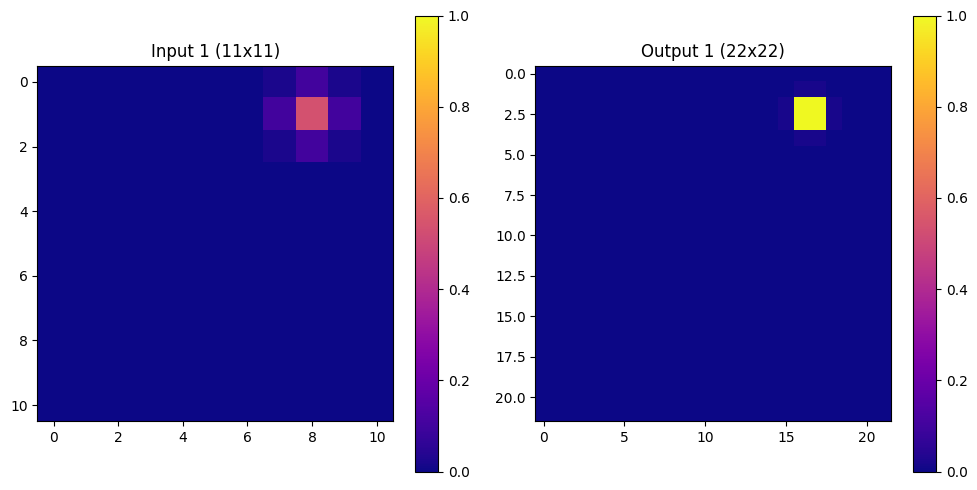

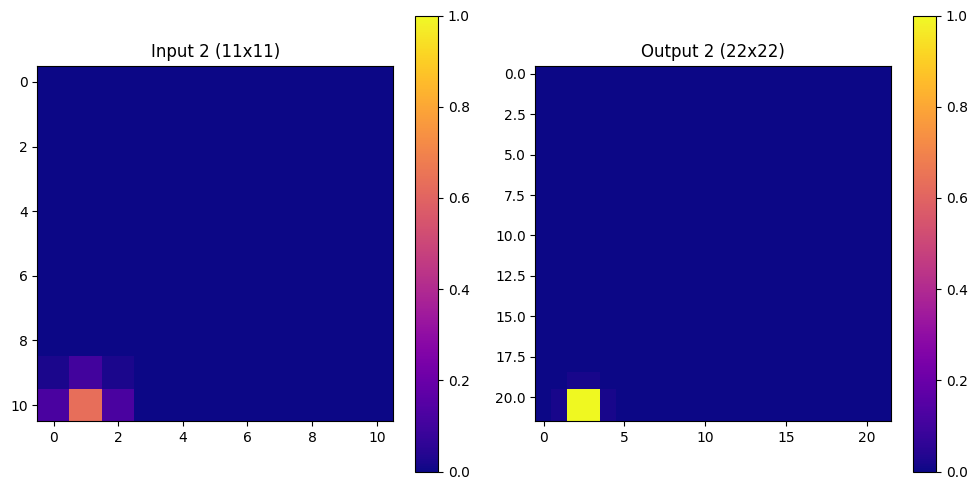

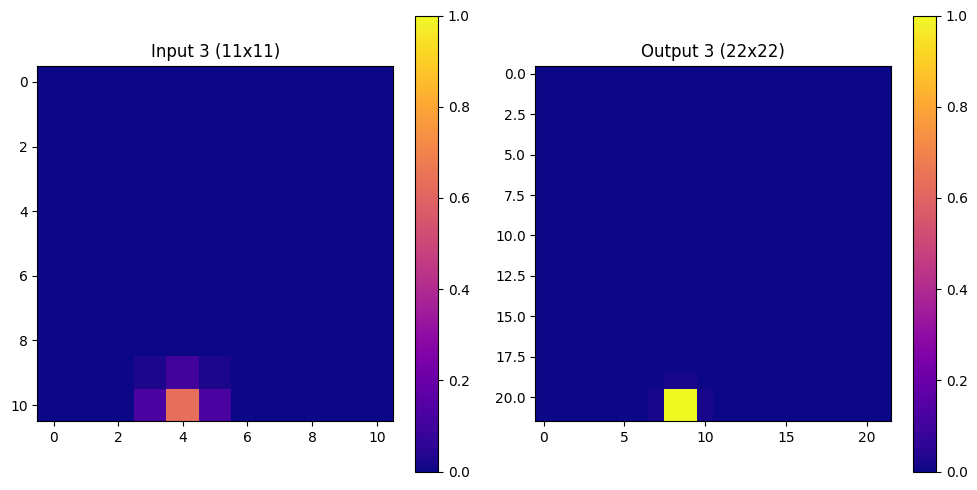

Saved 1000 real training samples
Training model on real data...
Using device: cuda
Epoch [0/100], Loss: 0.179102, LR: 1.00e-04


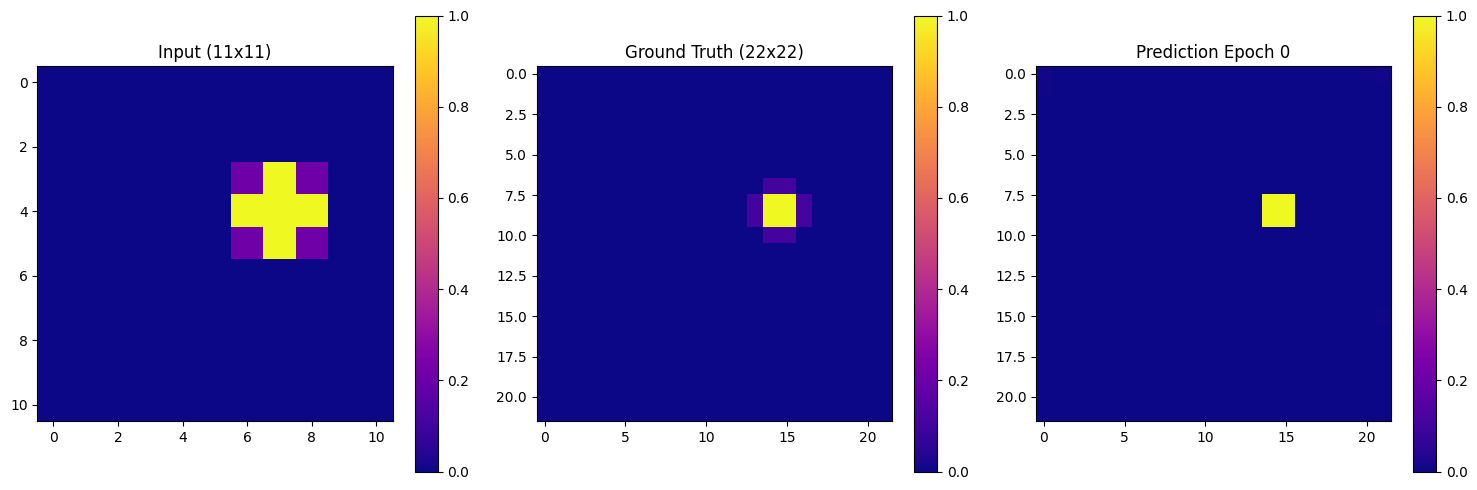

Epoch [10/100], Loss: 0.008988, LR: 1.00e-04
Epoch [20/100], Loss: 0.009026, LR: 1.00e-04


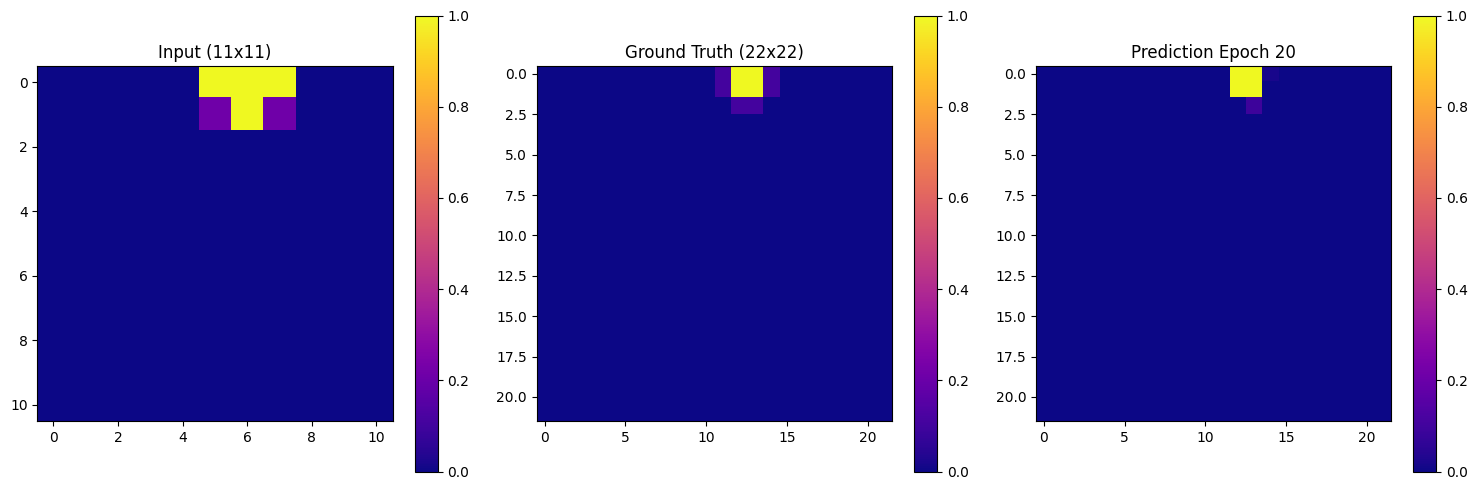

Epoch [30/100], Loss: 0.008848, LR: 1.00e-04
Epoch [40/100], Loss: 0.008931, LR: 1.00e-04


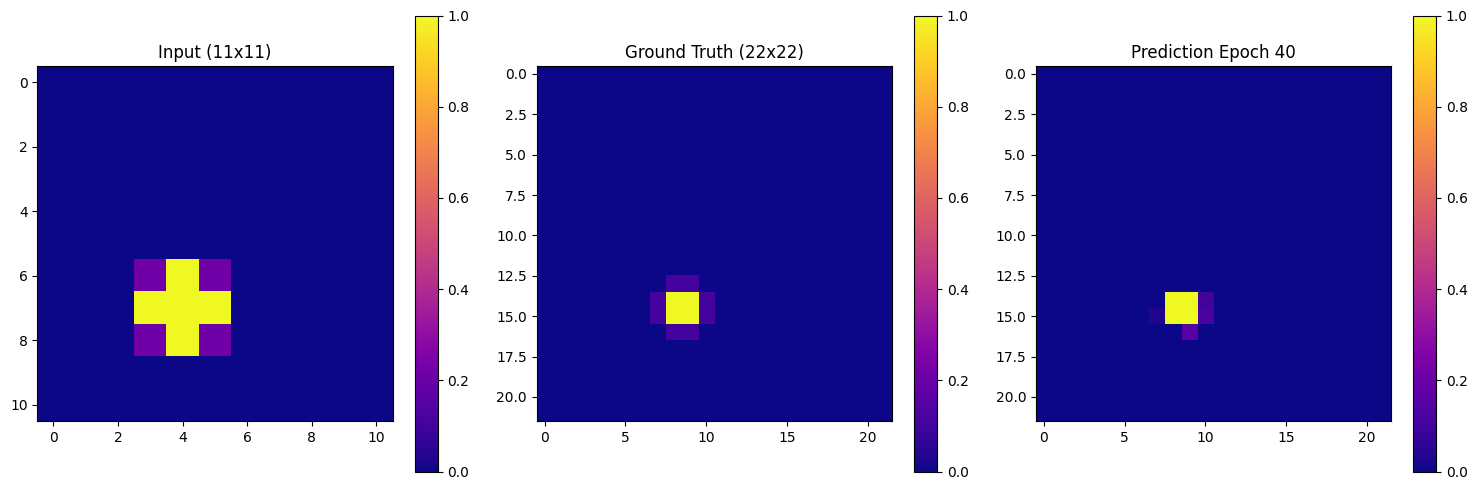

Epoch [50/100], Loss: 0.008793, LR: 1.00e-04
Epoch [60/100], Loss: 0.008753, LR: 5.00e-05


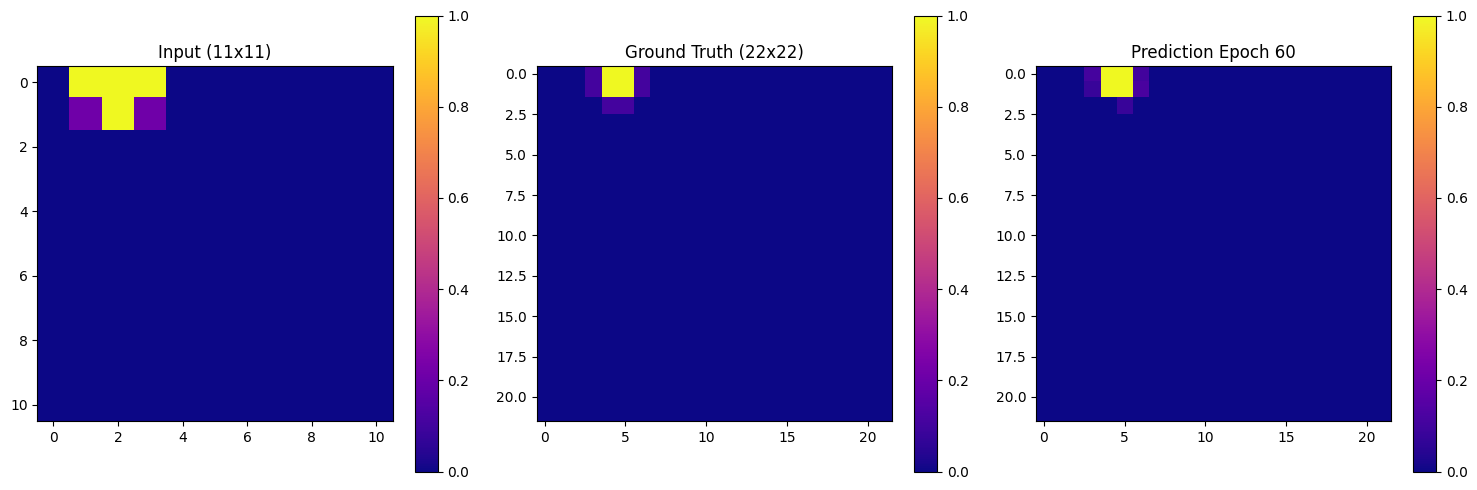

Epoch [70/100], Loss: 0.008750, LR: 5.00e-05
Epoch [80/100], Loss: 0.008744, LR: 5.00e-05


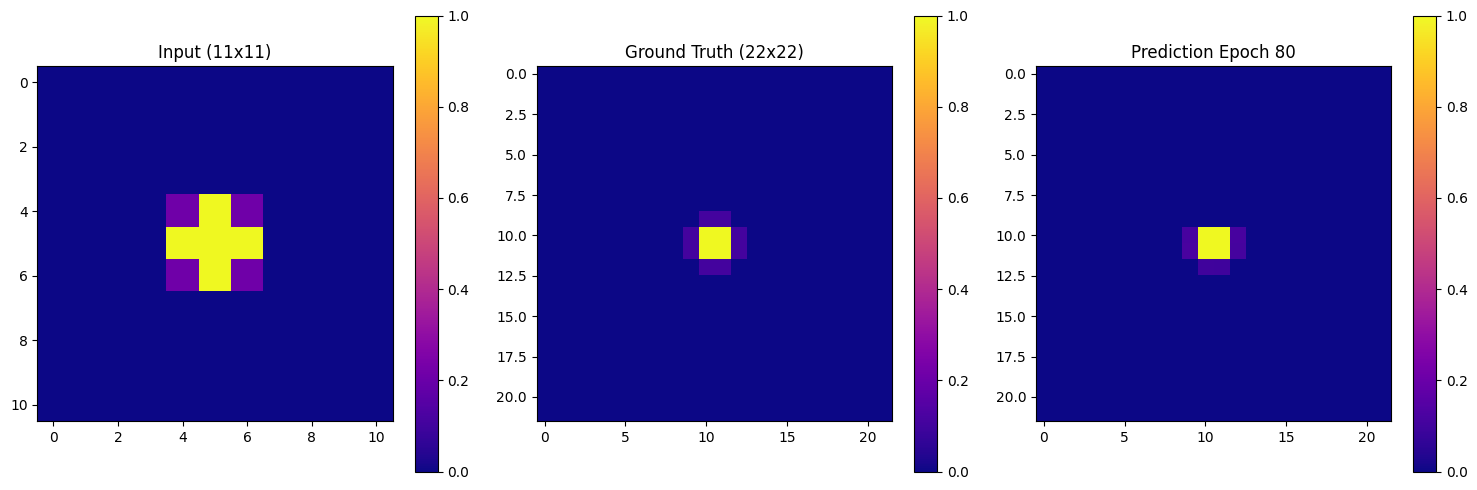

Epoch [90/100], Loss: 0.008736, LR: 2.50e-05


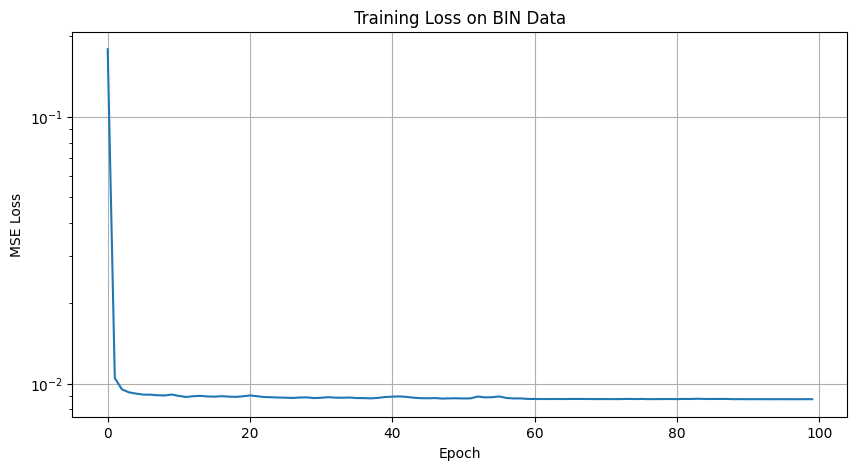

Model saved!


In [32]:
def run_on_bin():
    print("Loading binary data...")
    data_loader = Ideas(BINARY_DATA)
    data_loader.preprocess_events()

    print("Creating training data from detector events...")
    sampleData_in, sampleData_out = create_real_detector_data(
        data_loader,
        n_samples=1000,  # based on data size
        low_res_size=11,
        high_res_size=22
    )

    np.save('real_detector_data_in.npy', sampleData_in)
    np.save('real_detector_data_out.npy', sampleData_out)
    print(f"Saved {len(sampleData_in)} real training samples")

    print("Training model on real data...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = DetectorDataset(sampleData_in, sampleData_out)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = SimpleSuperResNet(input_size=11, output_size=22).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Lower LR
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    n_epochs = 100
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0

        for batch_idx, (input_imgs, target_imgs) in enumerate(dataloader):
            input_imgs = input_imgs.to(device)
            target_imgs = target_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(input_imgs)

            # Check for NaN values
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs at epoch {epoch}, batch {batch_idx}")
                continue

            loss = criterion(outputs, target_imgs)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        if batch_count == 0:
            print(f"Epoch {epoch}: No valid batches")
            continue

        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {avg_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')

        if epoch % 20 == 0:
            visualize_results(model, dataset, device, epoch)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss on BIN Data')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'superres_real_detector_model.pth')
    print("Model saved!")


def visualize_results(model, dataset, device, epoch):
    model.eval()
    with torch.no_grad():
        idx = np.random.randint(len(dataset))
        input_img, target_img = dataset[idx]

        pred = model(input_img.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()
        input_img = input_img.squeeze().numpy()
        target_img = target_img.squeeze().numpy()

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        im0 = axes[0].imshow(input_img, cmap='plasma', vmin=0, vmax=1)
        axes[0].set_title('Input (11x11)')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(target_img, cmap='plasma', vmin=0, vmax=1)
        axes[1].set_title('Ground Truth (22x22)')
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(pred, cmap='plasma', vmin=0, vmax=1)
        axes[2].set_title(f'Prediction Epoch {epoch}')
        plt.colorbar(im2, ax=axes[2])

        plt.tight_layout()
        plt.show()


run_on_bin()